# Overview notebook on "CMIP6 data analysis with PCMCI"

Import of the relevant package, the most important ones being :
    - iris, used for the handling of the climate data file
    - tigramite which includes the PCMCI implementation

In [1]:
#!jupyter nbconvert  "Overview of the project - Notebook - CMIP6.ipynb" --to pdf

In [1]:
import glob
from matplotlib import pyplot as plt
%matplotlib inline
## use `%matplotlib notebook` for interactive figures
import pickle
# plt.style.use('ggplot')
#import iris
import numpy as np
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
import pandas as pd
import scienceplots
plt.style.use(['science','nature'])
# plt.style.use(['science','nature'])

Decide what to run to avoid running heavy cells without noticing :), by default the iPyNB only run plot

In [2]:
run_preprocessing = False
run_PCMCI = False
run_PCA = False
save_res= True
make_dic= False
use_CMIP6_data=True
plot_figure = True
time_bin=1

Define paths to CMIP5 or CMIP6 data folders depending on use_CMIP6_data boolean value for the rest of the notebook

In [3]:
if use_CMIP6_data:
    #define all paths to CMIP6 data folders
    

    #all psl paths
    psl_1979_2014_path="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/detrend_data/"
    pca_res_path="/work/bd1083/b309165/CMIP6_CME/output_pca/CMIP6_era5_1979-2014_weights_timebin1/"
    #pcmci_res_path="/work/bd1083/b309165/CMIP6_CME/output_pcmci/CMIP6_ncar_1979-2014_weights_and_pr_mean_timebin1x2_alllinks/"
    pcmci_res_path="/work/bd1083/b309165/CMIP6_CME/output_pcmci/CMIP6_era5_1979-2014_weights_timebin1x2_60selectedcomps_taumax20/"
    #pr paths
    pr_histo_path = "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1979-2014_pr_study_timebinned_masked/"
    pr_scenario_path = "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/%s_data/"
    #piControl_path= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/piControl_data/"
    pr_1979_2014_path= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1979-2014_data/"
    #csv/bin output files
    global_res_path = "/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_link_and_parents_1979-2014_era5_weights_psl_timebin1x2_60selectedcomps_taumax20.bin"
    delta_precip_file="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/delta_precip_histo_1860-1910_vs_%s_2050-2100_final_version.csv"
    sscore_file="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/seasonnal_S_score_model_versus_%s.csv"
   

In [4]:
make_dic= False

In [5]:
save_global_res= True #only used if make_dic=True
selected_comps_indices=[i for i in range(0,60)]
var_names=["X_"+str(i) for i in range(0,60)]
alpha_list = [0.001,0.0001,0.00001] #[0.01,0.001,0.0001,0.00001]
if make_dic:
    link_mat_alpha_dic = {}
    link_mat_dic= {}
    val_mat_dic={}
    val_mat_alpha_dic={}
    p_mat_dic={}
    p_mat_alpha_dic={}
    q_mat_dic={}
    q_mat_alpha_dic={}
    ak_dic={}
    ak_alpha_dic={}
    for alpha_level in alpha_list:
        for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):

            res = pickle.load(open(res_file,"rb"))
            results= res["results"]
            file_name = res['file_name']
            info_model= file_name.split("_")
            dataset_name = info_model[2]
            ensemble=""
            if dataset_name != "ERA5":
                dataset_name= info_model[2]
                if use_CMIP6_data:
                    ensemble= info_model[5]
                else : ensemble= info_model[7]
            if dataset_name == "GISS-E2-R":
                ensemble= info_model[5]
            season= info_model[-1][7:-4]

            print("Current model, ensemble, season : "+dataset_name+" "+ensemble+" "+season )
            file_path = pca_res_path+"/"+ file_name
            datadict = pickle.load(open(file_path, 'rb'))
            d = datadict['results']
            time_mask = d['time_mask']
            fulldata = d['ts_unmasked']
            N = 60
            fulldata_mask = np.repeat(time_mask.reshape(len(d['time']), 1), N, axis=1)
            fulldata = fulldata[:, 0:N]
            fulldata_mask = fulldata_mask[:, 0:N]
            dataframe = pp.DataFrame(fulldata, mask=fulldata_mask)
            
            CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
            cond_ind_test = ParCorr(**CI_params)
            pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframe)
            tau_max=10
            # region_list= ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]
            # dict_selected_links={}
            # preselected_links= {(var,-tau):'-?>' for var in range(N-len(region_list)) for tau in range(1,tau_max+1)}
            # for key_dict in range(N-len(region_list)):
            #     dict_selected_links[key_dict]= {(var,-tau):'-?>'
            #             for var in range(N-len(region_list))
            #             for tau in range(1,tau_max+1)
            #             if not (var == key_dict and tau == 0)}
            # for key_dict in range(N-len(region_list),N):
            #     dict_selected_links[key_dict] = preselected_links #modes towards pr region
            #     dict_selected_links[key_dict].update({(key_dict,-tau):'-?>' for tau in range(1,tau_max+1)})#auto links
            # #print(dict_selected_links.keys())
            # #final_graph = results['p_matrix'] <= alpha_level
            # #graph = pcmci.convert_to_string_graph(final_graph)
            # graph = pcmci.get_graph_from_pmatrix(results['p_matrix'], alpha_level, tau_min=1, tau_max=10, link_assumptions=dict_selected_links)
            # for i in range(N):
            #     for j in range(N):
            #         for tau in range(tau_max):
            #             if graph[i,j,tau]=="o-o" or graph[i,j,tau]=="x-x": graph[i,j,tau]=""
            #val_mat,AK = get_val_matrix_and_AK(file_path,file_name,graph)
            # val_mat,AK=0,0
            val_mat_dic.setdefault(season,{})
            val_mat_dic[season].setdefault(dataset_name,{})
            val_mat_dic[season][dataset_name].setdefault(ensemble,None)
            val_mat_dic[season][dataset_name][ensemble]= results['val_matrix']
            p_mat_dic.setdefault(season,{})
            p_mat_dic[season].setdefault(dataset_name,{})
            p_mat_dic[season][dataset_name].setdefault(ensemble,)
            p_mat_dic[season][dataset_name][ensemble]= results['p_matrix']
            # ak_dic.setdefault(season,{})
            # ak_dic[season].setdefault(dataset_name,{})
            # ak_dic[season][dataset_name].setdefault(ensemble,)
            # ak_dic[season][dataset_name][ensemble]= AK


        p_mat_alpha_dic[alpha_level]= p_mat_dic
        val_mat_alpha_dic[alpha_level]= val_mat_dic
        # ak_alpha_dic[alpha_level]= ak_dic

        
    global_res = {"p_val":p_mat_alpha_dic,"val_mat":val_mat_alpha_dic}#,"AK_matrix":ak_alpha_dic}

    if save_global_res :
        print("Writing global results file: "+global_res_path)
        with open(global_res_path, 'wb') as file:
            pickle.dump(global_res, file)

else:
    with open(global_res_path, 'rb') as file:
        global_res = pickle.load(file)

Define modified F1-score from Nowack's paper

In [6]:
def get_regional_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, kept_nodes, 
            tau_min=0, tau_diff=1, same_sign=True):
    #ref_p_matrix= ref_p_matrix[kept_nodes,:][:,kept_nodes,:]
    #p_matrix= p_matrix[kept_nodes,:][:,kept_nodes,:]
    #ref_val_matrix= ref_val_matrix[kept_nodes,:][:,kept_nodes,:]
    #val_matrix= val_matrix[kept_nodes,:][:,kept_nodes,:]
    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    if len(kept_nodes)<1: return [np.nan]*8
    for i in range(N):
        #We keep only links in between kept_nodes and from other nodes towards kept_nodes.
        #To achieve that, we restrict only the columns to kept_nodes
        for j in kept_nodes:
            if i != j:
                for tau in range(tau_min, taumaxp1):
#                     print(np.sum(ref_p_matrix[i,j,tau] < alpha),np.sum(p_matrix[i,j,tau] < alpha))
                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                        FP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                        count +=1
                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                            TP += 1
                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                            FN += 1
                        elif same_sign==False:
                            TP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                        FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

#Function to compute WDM from p_matrices and val_matrices
def get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, 
            tau_min=0, tau_diff=1, same_sign=True):

    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                for tau in range(tau_min, taumaxp1):
#                     print(np.sum(ref_p_matrix[i,j,tau] < alpha),np.sum(p_matrix[i,j,tau] < alpha))
                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                        FP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                        count +=1
                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                            TP += 1
                            # if tau > 10:
                            #     print("TP for lag %d found" %tau)
                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                            FN += 1
                        elif same_sign==False:
                            TP += 1
                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                        FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

def get_LRE(AK):
    return np.linalg.inv(np.eye(AK.shape[0])-AK)

Create a panda DataFrame containing all F1-score against NCAR network for all seasons for all available model,ensembles

In [7]:
####This cell creates df_f1score pandasframe which stores WDM for all season,model,ensemble triplets
alpha = 0.00001
ref_ds="ERA5"
p_mat_dic=global_res["p_val"][alpha]
val_mat_dic= global_res["val_mat"][alpha]
#ak_mat_dic = global_res["AK_matrix"][alpha]
score_list =[]
for season in p_mat_dic:
    if season !="global":#drop global
        for dataset in p_mat_dic[season]:
            for ensemble in p_mat_dic[season][dataset]:
                if dataset!=ref_ds:
                    ref_p_matrix= p_mat_dic[season][ref_ds][""]
                    p_matrix= p_mat_dic[season][dataset][ensemble]
                    ref_val_matrix= val_mat_dic[season][ref_ds][""]
                    val_matrix= val_mat_dic[season][dataset][ensemble]
                    #print(kept_nodes)
                    precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:60,:60,:], p_matrix[:60,:60,:], ref_val_matrix[:60,:60,:], val_matrix[:60,:60,:],
                    alpha, tau_min=1, tau_diff=2, same_sign=True) #tau_diff=3
                    score_list.append([season,dataset,ensemble,score])

season,dataset,ensemble,score= [list(a) for a in zip(*score_list)]
df_f1score_global = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"F1-score":score})
#if not use_CMIP6_data : df_f1score.loc[df_f1score['model'] == "GISS-E2-R","ensemble"]="r1i1p1" #fix for GISS ensemble being wrong
#get average F1-score over seasons
df_f1score_seasonaveraged_global = df_f1score_global.groupby(["model","ensemble"])["F1-score"].mean().rename("F1-score",inplace=True).to_frame()
df_f1score_seasonaveraged_global

F1-score
model         ensemble          
ACCESS-CM2    r1i1p1f1  0.690611
              r2i1p1f1  0.686507
              r3i1p1f1  0.693884
ACCESS-ESM1-5 r1i1p1f1  0.663627
              r2i1p1f1  0.656960
...                          ...
UKESM1-0-LL   r5i1p1f3  0.693278
              r6i1p1f3  0.699181
              r7i1p1f3  0.693419
              r8i1p1f2  0.696882
              r9i1p1f2  0.693293

[169 rows x 1 columns]

In [8]:
to_keep = ["FGOALS-g3_r1i1p1f1","FGOALS-g3_r3i1p1f1","KACE-1-0-G_r3i1p1f1","MIROC-ES2L_r10i1p1f2","MIROC-ES2L_r1i1p1f2",
"MIROC-ES2L_r2i1p1f2","MIROC-ES2L_r3i1p1f2","MIROC-ES2L_r4i1p1f2","MIROC-ES2L_r5i1p1f2","MIROC-ES2L_r6i1p1f2",
"MIROC-ES2L_r7i1p1f2","MIROC-ES2L_r8i1p1f2","MIROC-ES2L_r9i1p1f2","MIROC6_r10i1p1f1","MIROC6_r1i1p1f1","MIROC6_r2i1p1f1",
"MIROC6_r3i1p1f1","MIROC6_r4i1p1f1","MIROC6_r5i1p1f1","MIROC6_r6i1p1f1","MIROC6_r7i1p1f1","MIROC6_r8i1p1f1","MIROC6_r9i1p1f1",
"MPI-ESM1-2-HR_r1i1p1f1","MPI-ESM1-2-HR_r2i1p1f1","MPI-ESM1-2-LR_r10i1p1f1","MPI-ESM1-2-LR_r1i1p1f1","MPI-ESM1-2-LR_r2i1p1f1",
"MPI-ESM1-2-LR_r3i1p1f1","MPI-ESM1-2-LR_r4i1p1f1","MPI-ESM1-2-LR_r5i1p1f1","MPI-ESM1-2-LR_r6i1p1f1","MPI-ESM1-2-LR_r7i1p1f1",
"MPI-ESM1-2-LR_r8i1p1f1","MPI-ESM1-2-LR_r9i1p1f1","MRI-ESM2-0_r1i1p1f1","MRI-ESM2-0_r1i2p1f1","MRI-ESM2-0_r2i1p1f1",
"MRI-ESM2-0_r3i1p1f1","MRI-ESM2-0_r4i1p1f1","MRI-ESM2-0_r5i1p1f1","NorESM2-LM_r1i1p1f1","UKESM1-0-LL_r1i1p1f2","UKESM1-0-LL_r2i1p1f2",
"UKESM1-0-LL_r3i1p1f2","UKESM1-0-LL_r4i1p1f2","KACE-1-0-G_r2i1p1f1","KACE-1-0-G_r1i1p1f1","ACCESS-CM2_r1i1p1f1","ACCESS-CM2_r2i1p1f1",
"ACCESS-CM2_r3i1p1f1","ACCESS-ESM1-5_r1i1p1f1","ACCESS-ESM1-5_r2i1p1f1","ACCESS-ESM1-5_r3i1p1f1","BCC-CSM2-MR_r1i1p1f1",
"CESM2_r1i1p1f1","CESM2-WACCM_r1i1p1f1","CESM2-WACCM_r2i1p1f1","CESM2-WACCM_r3i1p1f1","CNRM-CM6-1_r1i1p1f2","CNRM-CM6-1_r2i1p1f2",
"CNRM-CM6-1_r3i1p1f2","CNRM-CM6-1_r4i1p1f2","CNRM-CM6-1_r5i1p1f2","CNRM-CM6-1_r6i1p1f2","CNRM-ESM2-1_r1i1p1f2",
"CNRM-ESM2-1_r2i1p1f2","CNRM-ESM2-1_r3i1p1f2","CNRM-ESM2-1_r4i1p1f2","CNRM-ESM2-1_r5i1p1f2","CanESM5_r10i1p1f1",
"CanESM5_r1i1p1f1","CanESM5_r1i1p2f1","CanESM5_r2i1p1f1","CanESM5_r2i1p2f1","CanESM5_r3i1p1f1",
"CanESM5_r3i1p2f1","CanESM5_r4i1p1f1","CanESM5_r4i1p2f1","CanESM5_r5i1p1f1","CanESM5_r6i1p1f1",
"CanESM5_r7i1p1f1","CanESM5_r8i1p1f1","CanESM5_r9i1p1f1","EC-Earth3_r11i1p1f1",
"EC-Earth3_r1i1p1f1","EC-Earth3_r4i1p1f1","EC-Earth3-Veg_r1i1p1f1","EC-Earth3-Veg_r2i1p1f1",
"EC-Earth3-Veg_r3i1p1f1","EC-Earth3-Veg_r4i1p1f1","HadGEM3-GC31-LL_r1i1p1f3","HadGEM3-GC31-LL_r2i1p1f3",
"HadGEM3-GC31-LL_r3i1p1f3","HadGEM3-GC31-LL_r4i1p1f3","HadGEM3-GC31-MM_r1i1p1f3",
"HadGEM3-GC31-MM_r2i1p1f3","HadGEM3-GC31-MM_r3i1p1f3","HadGEM3-GC31-MM_r4i1p1f3",
"INM-CM5-0_r1i1p1f1","IPSL-CM6A-LR_r1i1p1f1","IPSL-CM6A-LR_r2i1p1f1","IPSL-CM6A-LR_r3i1p1f1","IPSL-CM6A-LR_r4i1p1f1","IPSL-CM6A-LR_r6i1p1f1"]
model_to_keep = list(set([model_ensemble.split("_")[0] for model_ensemble in to_keep]))

In [22]:
df_f1score_seasonaveraged_global = df_f1score_seasonaveraged_global.loc[df_f1score_seasonaveraged_global.index.get_level_values('model').isin(model_to_keep)]

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pylab
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
%matplotlib inline
def poly_fit_linear_Sscore(x, y, title,xlabel,ylabel):
    plt.rcParams['figure.figsize'] = (5, 4)
    degree = 1
    polynomial_features= PolynomialFeatures(degree=degree)
    xp = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = sm.OLS(y, xp).fit()
    ypred = model.predict(xp) 
    print(model.pvalues[-1])
    print(model.rsquared)

    plt.plot(x,ypred)
    plt.scatter(x,y)
    plt.xlabel(xlabel,size=20)
    plt.ylabel(ylabel,size=20)
    plt.title(title)
    plt.show()
    #plt.close()

import scipy.stats as stats
import matplotlib.pyplot as plt
def plot_linregress(S_scores_list,scores_avg_1e6,region,xlabel,ylabel):
    pylab.rcParams['figure.figsize'] = (5, 4)
    plt.rc('text', usetex=False)
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_scores_list, scores_avg_1e6)
    xmin=np.min(S_scores_list-0.05)
    xmax=np.max(S_scores_list+0.05)
    ymin=np.min(scores_avg_1e6)-0.02
    ymax=np.max(scores_avg_1e6)+0.01
    reg_line=intercept+slope*np.arange(0.02,1.0,0.02)
    print("p-value %5f" %p_value)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.scatter(S_scores_list,scores_avg_1e6,color='blue',marker='s',s=120)
    plt.plot(np.arange(0.02,1.0,0.02),reg_line,color='b',linewidth=3,linestyle='--')
    plt.xlabel(xlabel,size=20)
    plt.ylabel(ylabel,size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.figtext(0.15,0.825,'R = '+str('%.2f' % round(r_value,2))+', p = '+str('%.5f' % round(p_value,5)),size=20,color='b')
    plt.title(region,fontweight='bold',size=20)
    plt.show()

### c.) Fit of the Delta-precip vs F1-score

#### Fitting F1-score averaged on all ensembles v. Delta-precip using a GPR, Polynomial regression, linear regression for SELECTED MODELS

F1-score v. DeltaPrecip for SSP585

In [23]:
pr_ssp585_2050_2099_regridtoNCEP= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp585_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp370_2050_2099_regridtoNCEP= "/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp370_2050-2099_regridtoNCEP_extract_region_mean/"
pr_ssp245_2050_2099_regridtoNCEP="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/ssp245_2050-2099_regridtoNCEP_extract_region_mean/"
pr_histo_1860_1910_regridtoNCEP="/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/histo_1860-1910_regridtoNCEP_extract_region_mean/"
deltaPrecip_result_template="/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/regional_deltaPrecip_%s_scenario_regridtoNCEP.csv"
mask_list = ["North-America","South-America","Europe","Africa","South-Asia","East-Asia","Oceania"]

In [24]:
import pandas as pd
import numpy as np
#import xarray as xr
import os
import glob
import pickle
# import iris
# import iris.analysis.stats
import warnings
# import iris.coord_categorisation
warnings.simplefilter("ignore")
import copy

def compute_mean_diff(histo_cube,ssp_cube):
    spatial_diff= ssp_cube - histo_cube
    #compute area weighted mean
    try :
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    except ValueError:
        lat= spatial_diff.coord("latitude")
        lon= spatial_diff.coord("longitude")
        lon.guess_bounds()
        lat.guess_bounds()
        area_weighted_mean = float(spatial_diff.collapsed(["latitude","longitude"],iris.analysis.MEAN,weights=iris.analysis.cartography.area_weights(spatial_diff)).data)
    return area_weighted_mean

def get_delta_precip(pr_histo_1860_1910_path, pr_scenario_path, scenario_name,make_dic,save_res,result_file_name,mask_list):
#Compute Precipitation difference on climatology between two periods for all model datasets.
#Saved in a dictionnary
    if make_dic:

        res_list=[]
        model_list=[]
        ensemble_list=[]
        region_list= []
        for region in mask_list:
            source_path_scenario = pr_scenario_path+"/"+region+"/"
            source_path_histo = pr_histo_1860_1910_path+"/"+region+"/"

            print(source_path_scenario+"/CMIP*.nc")
            for file_ in glob.glob(source_path_scenario+"/CMIP*.nc"):
                print(file_)
                try:
                    rcp85_file_name= os.path.basename(file_)
                    model_name= os.path.basename(rcp85_file_name).split("_")[1]
                    ensemble= os.path.basename(rcp85_file_name).split("_")[4]
                    if scenario_name =="rcp85":
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                    #elif scenario_name == "abrupt-4xCO2":
                    #    histo_file_name= glob.glob(piControl_path + "*"+model_name+"*.nc")[0]
                    #elif scenario_name == "abrupt-4xCO2_2" or scenario_name == "abrupt-4xCO2_130-150":
                    #    histo_file_name= glob.glob("/work/bd1083/b309165/CMIP6_CME/data/CMIP6_data/pr_data/piControl_2_data/" + "*" + model_name + "*.nc")[0]
                    else:
                        histo_file_name= source_path_histo+rcp85_file_name.replace("2050","1860").replace("2099","1910").replace(scenario_name,"historical")
                        #if "NorESM2-LM" in rcp85_file_name:
                        #    histo_file_name = source_path_histo+histo_file_name.replace("r1i1p1f1","r2i1p1f1")

                    print("Computing Delta Precipitation between "+ scenario_name+" 2050-2100 and  1860-1910 for "+model_name+" "+ensemble)
                    #LOAD CUBE
                    rcp85_cube = iris.load_cube(file_,"precipitation_flux")
                    #print(source_path_histo+histo_file_name)
                    histo_cube = iris.load_cube(histo_file_name,"precipitation_flux")

                    #COMPUTE DIFF
                    diff_ = compute_mean_diff(histo_cube,rcp85_cube)
                    model_list.append(model_name)
                    ensemble_list.append(ensemble)
                    region_list.append(region)
                    res_list.append(diff_)
                    del histo_cube
                    del rcp85_cube
                except Exception as e:
                    print(e)
                    pass

        model,ensemble,region_list,res_list= (list(t) for t in zip(*sorted(zip(model_list,ensemble_list,region_list,res_list))))
        df_deltaPrecip= pd.DataFrame({"model":model,"ensemble":ensemble,"region":region_list,"deltaPrecip":res_list})
        if save_res:
            print("Now saving results in CSV format")
            df_deltaPrecip.to_csv(result_file_name)
    else:
        print("Loading file")
        df_deltaPrecip= pd.read_csv(result_file_name)
        df_deltaPrecip.drop("Unnamed: 0",axis=1,inplace=True)


    #Convert unit from kg/m2/s to mm/day
    df_deltaPrecip.loc[:,"deltaPrecip"]*=86400
    print(df_deltaPrecip.to_string())
    return(df_deltaPrecip)

In [25]:
make_dic=False
save_res= True
scenario_name = "ssp585"
df_deltaPrecip_ssp585 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp585_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp370"
df_deltaPrecip_ssp370 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp370_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)
scenario_name = "ssp245"
df_deltaPrecip_ssp245 = get_delta_precip(pr_histo_1860_1910_regridtoNCEP, pr_ssp245_2050_2099_regridtoNCEP, scenario_name,
                 make_dic,save_res,deltaPrecip_result_template%scenario_name,mask_list)

make_dic= False

Loading file
               model  ensemble         region  deltaPrecip
0         ACCESS-CM2  r1i1p1f1         Africa     0.273723
1         ACCESS-CM2  r1i1p1f1      East-Asia     0.481154
2         ACCESS-CM2  r1i1p1f1         Europe     0.210783
3         ACCESS-CM2  r1i1p1f1         Global     0.216845
4         ACCESS-CM2  r1i1p1f1  North-America     0.327188
5         ACCESS-CM2  r1i1p1f1        Oceania    -0.007148
6         ACCESS-CM2  r1i1p1f1  South-America    -0.152244
7         ACCESS-CM2  r1i1p1f1     South-Asia     0.735578
8      ACCESS-ESM1-5  r1i1p1f1         Africa     0.205291
9      ACCESS-ESM1-5  r1i1p1f1      East-Asia     0.174964
10     ACCESS-ESM1-5  r1i1p1f1         Europe     0.064408
11     ACCESS-ESM1-5  r1i1p1f1         Global     0.039619
12     ACCESS-ESM1-5  r1i1p1f1  North-America     0.221718
13     ACCESS-ESM1-5  r1i1p1f1        Oceania    -0.501097
14     ACCESS-ESM1-5  r1i1p1f1  South-America    -0.572041
15     ACCESS-ESM1-5  r1i1p1f1     South-As

In [ ]:
#Author: Peer Nowack
import numpy as np
import pylab
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
%matplotlib inline

# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n%s" % gp.kernel_
    s2 = "\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    return (s1 + s2)

def gaussian_process_fit(x, y,plot_title):

#     x -= x.mean()
#     x/=x.std()
    
#     y -= y.mean()
#     y/=y.std()
    
    # Specify observations
    n_obs = len(x)
    X_obs = x.reshape(n_obs, 1)
    x_min = x.min() - .1*(x.max()-x.min())
    x_max = x.max() + .1*(x.max()-x.min())
    f_obs = y
    
    #KERNEL used
    kernel = 10 * RBF(1, (1e-3, 1e3)) + WK(1)
#     kernel = 1 * M(1, (1e-2, 1e2), nu = 5/2) + WK(1)

    gp = GPR(kernel=kernel, alpha = 0.00000001, n_restarts_optimizer=20)
    gp.fit(X_obs, f_obs)
    print(summary(gp))

    # Make a prediction on test points
    X_test = np.array(np.linspace(x_min, x_max, 1000), ndmin = 2).T
    f_mean, f_var = gp.predict(X_test, return_std=True)

    # Create a Plot
    fig_noisy = plt.figure(figsize = (5,4))
    plt.rcParams.update({'font.size': 12})

    # Mark the observations
    plt.plot(X_obs, f_obs, 'ro', label='CMIP6 models')

    # Draw a mean function and 95% confidence interval
    plt.plot(X_test, f_mean, 'b-', label='mean function')
    upper_bound = f_mean + 1.96 * f_var
    lower_bound = f_mean - 1.96 * f_var
    plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.2,
                     label='95% confidence interval')

    # Draw samples from the posterior and plot
    # X_samples = np.array(np.linspace(x_min, x_max, 30), ndmin = 2).T
    # seed = np.random.randint(10) # random seed
    # plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

    # Aesthetics
    plt.xlabel('$\Delta$ Precipitation over land (mm/day)',size=24)
    plt.ylabel('Regional F1-score',size=24)
    plt.xlim(x_min, x_max)
    plt.title(plot_title)
    #plt.xlim(-0.05, 0.20)
    # plt.ylim(-3, 3)
    plt.legend(loc='lower left')
#     plt.title(summary(gp))
    plt.show()

# def poly_fit_test(x, y,nickname, pvalue,title):
#     plt.rcParams['figure.figsize'] = (5, 4)
#     degree = 2

#     df = pd.DataFrame(columns=['y', 'x'])
#     df['x'] = x
#     df['y'] = y

#     weights = np.polyfit(x, y, degree)
#     model = np.poly1d(weights)
#     #print (model)
#     results = smf.ols(formula='y ~ model(x)', data=df).fit()
#     #print(results.summary())
#     p_val_poly= results.pvalues[1]
#     r_squared = results.rsquared
    
#     x_min = x.min() - .3*(x.max()-x.min())
#     x_max = x.max() + .3*(x.max()-x.min())
#     y_min = y.min() - .05*(y.max()-y.min())
#     y_max = y.max() + .05*(y.max()-y.min())    
#     # Make a prediction on test points
#     X_test = np.linspace(x_min, x_max, 1000)
#     f_mean = model(X_test)
# #     print (f_mean)
#     # Create a Plot
#     fig = plt.figure(figsize = (5,4))
#     params = {'legend.fontsize': 'small',
#           #'figure.figsize': (15, 5),
#          'axes.labelsize': 'large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
#     pylab.rcParams.update(params)
#     #plt.rcParams.update({'font.size': 16})
#     # Mark the observations
#     plt.plot(x, y, 'ko', label='CMIP6 models')
#     plt.ylim(y_min,y_max)
#     # Draw a mean function and 95% confidence interval
#     plt.plot(X_test, f_mean, 'r-', label=r'y = a+b$\cdot$x+c$\cdot$x$^2$')
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#     #print(slope, intercept, r_value, p_value)
#     reg_line=intercept+slope*np.arange(x_min,x_max,0.02)
#     plt.plot(np.arange(x_min,x_max,0.02),reg_line,color='b',linewidth=1,linestyle='--',label=r'y = a+b$\cdot$x')
#     # Aesthetics
#     plt.title(r'$F_1$ scores '+title)
#     # plt.figtext(0.15,0.825,'p = '+str(round(p_val_poly,5)),color='red')
#     # plt.figtext(0.15,0.775,'p = '+str(round(p_value,3)),color='blue')
#     plt.figtext(0.15, 0.825, 'p (poly) = ' + str(round(p_val_poly, 5)), color='red')
#     plt.figtext(0.15, 0.775, 'p (lin) = ' + str(round(pvalue, 3)), color='blue')
#     plt.figtext(0.15, 0.725, r'$R^2$ = ' + str(round(r_squared, 3)), color='green')
#     plt.xlabel('$\Delta$ Precipitation over land (mm.day$^-1$)')
#     plt.ylabel(r'$F_1$ score against ERA5')
#     plt.xlim(x_min, x_max)
#     # plt.ylim(-3, 3)
#     plt.legend(loc='lower left')
#     SSP = str(title.split(" ")[3])
#     savefile = 'precip_vs_F1_polyfit_60comp_'+SSP+'_ERA5.pdf'
#     print(savefile)
#     plt.savefig(savefile,dpi=300)
#     plt.show()

def poly_fit_test(x, y, nickname, pvalue, title):
    plt.rcParams['figure.figsize'] = (5, 4)
    degree = 2

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = y

    weights = np.polyfit(x, y, degree)
    model = np.poly1d(weights)

    # Fit the model using statsmodels
    results = smf.ols(formula='y ~ model(x)', data=df).fit()
    p_val_poly = results.pvalues[1]

    # Goodness-of-fit metrics
    r_squared = 1- results.ssr/results.uncentered_tss
    print(f"R^2: {r_squared:.3f}")

    # Confidence Interval Setup
    x_min = x.min() - .3 * (x.max() - x.min())
    x_max = x.max() + .3 * (x.max() - x.min())
    X_test = np.linspace(x_min, x_max, 1000)
    f_mean = model(X_test)

    # Compute confidence intervals (90% CI)
    X_poly = PolynomialFeatures(degree=degree).fit_transform(X_test.reshape(-1, 1))
    pred_std = np.sqrt(results.mse_resid * (1 + np.sum((X_poly - X_poly.mean(axis=0))**2, axis=1)))
    t_crit = stats.t.ppf(0.95, df=len(x) - degree - 1)  # 90% CI
    ci_upper = f_mean + t_crit * pred_std
    ci_lower = f_mean - t_crit * pred_std

    # Visualization
    fig = plt.figure(figsize=(5, 4))
    params = {'legend.fontsize': 'small',
              'axes.labelsize': 'large',
              'axes.titlesize': 'x-large',
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large'}
    pylab.rcParams.update(params)
    print(x)
    print(y)
    plt.plot(x, y, 'ko', label='CMIP6 models')
    plt.fill_between(X_test, ci_lower, ci_upper, color='red', alpha=0.2, label='90$\%$ Confidence Interval')
    plt.plot(X_test, f_mean, 'r-', label=r'y = a+b$\cdot$x+c$\cdot$x$^2$')

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    reg_line = intercept + slope * np.arange(x_min, x_max, 0.02)
    plt.plot(np.arange(x_min, x_max, 0.02), reg_line, color='b', linewidth=1, linestyle='--', label=r'y = a+b$\cdot$x')

    plt.title(r'$F_1$ scores ' + title)
    plt.figtext(0.15, 0.825, 'p (poly) = ' + str(round(p_val_poly, 5)), color='red')
    plt.figtext(0.15, 0.775, 'p (lin) = ' + str(round(p_value, 3)), color='blue')
    plt.figtext(0.15, 0.725, r'$R^2$ = ' + str(round(r_squared, 3)), color='green')
    plt.xlabel('$\Delta$ Precipitation over land (mm.day$^-1$)')
    plt.ylabel(r'$F_1$ score against ERA5')
    plt.xlim(x_min, x_max)
    plt.legend(loc='lower left')

    SSP = str(title.split(" ")[3])
    
    # Add figure label to the top-left corner
    figure_label = {'SSP5-8.5': '(d)', 'SSP3-7.0': '(e)', 'SSP2-4.5': '(f)'}.get(SSP, '')
    plt.text(0.02, 0.95, figure_label, transform=plt.gca().transAxes,
             fontsize=12, fontweight='bold', va='top', ha='left')
    
    savefile = 'precip_vs_F1_polyfit_60comp_' + SSP + '_ERA5.pdf'
    print(savefile)
    plt.savefig(savefile, dpi=300)
    plt.show()


# Global results

Fitted Kernel(Optimized)
0.673**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.000277)
log marginal likelihood: 53.64470


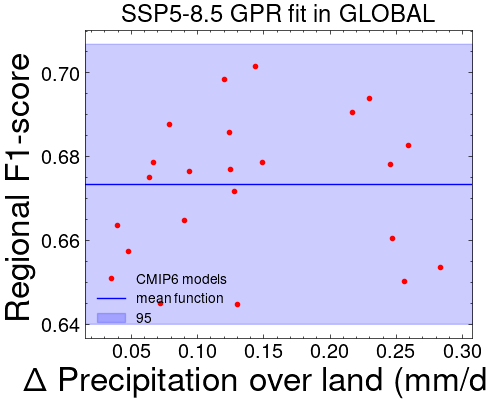

R^2: 0.01512
[0.21684499 0.03961893 0.07172358 0.0936575  0.0667125  0.12477611
 0.12421016 0.2562498  0.24526277 0.25918191 0.0897599  0.1201879
 0.2834579  0.24708424 0.22976681 0.13043111 0.14888362 0.07864825
 0.12744061 0.0638836  0.04778967 0.14351447]
[0.69061104 0.66362709 0.64504958 0.67654612 0.67866549 0.6771116
 0.68577099 0.65030663 0.67810199 0.68264603 0.66496429 0.69847934
 0.65358382 0.66045852 0.69389565 0.64490561 0.67866282 0.68767288
 0.67170355 0.67514118 0.6575046  0.70156993]
precip_vs_F1_polyfit_60comp_SSP5-8.5_ERA5.pdf


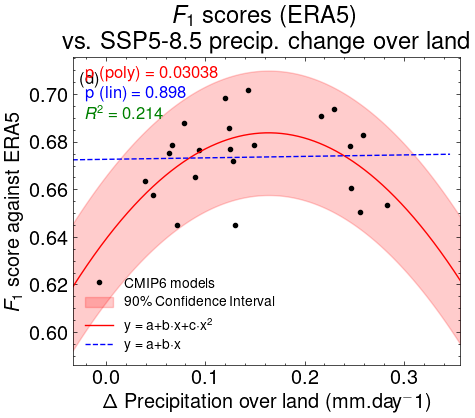

In [42]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp585[df_deltaPrecip_ssp585["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-g3" ].index
# # df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# # idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# # df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# # idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CNRM-CM6-1"].index
# # df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp585 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp585 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp585,f1_series_ssp585,"SSP5-8.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp585,f1_series_ssp585,"",0.01,"(ERA5) \n vs. SSP5-8.5 precip. change over land")

In [32]:
df_deltaPrecip_f1score

,model,ensemble,region,deltaPrecip,F1-score
0,ACCESS-CM2,r1i1p1f1,Global,0.216845,0.690611
1,ACCESS-ESM1-5,r1i1p1f1,Global,0.039619,0.663627
2,BCC-CSM2-MR,r1i1p1f1,Global,0.071724,0.645050
3,CESM2,r1i1p1f1,Global,0.093658,0.676546
4,CESM2-WACCM,r1i1p1f1,Global,0.066713,0.678665
5,CNRM-CM6-1,r1i1p1f2,Global,0.124776,0.677112
6,CNRM-ESM2-1,r1i1p1f2,Global,0.124210,0.685771
7,CanESM5,r1i1p1f1,Global,0.256250,0.650307
8,EC-Earth3,r1i1p1f1,Global,0.245263,0.678102
9,EC-Earth3-Veg,r1i1p1f1,Global,0.259182,0.682646


Fitted Kernel(Optimized)
0.676**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=0.00017)
log marginal likelihood: 44.26896


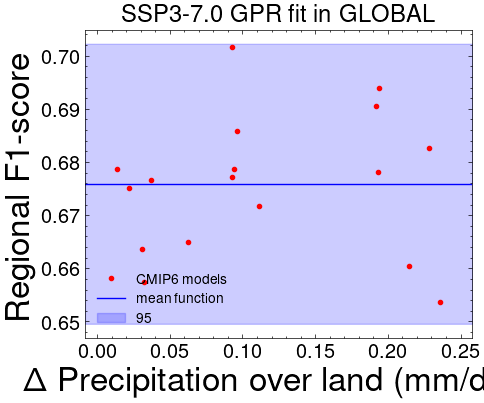

R^2: 0.21707
precip_vs_F1_polyfit_60comp_SSP3-7.0_ERA5.pdf


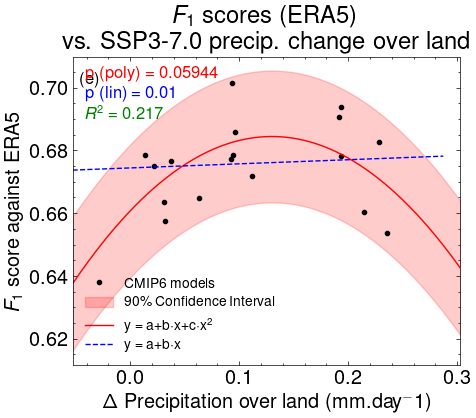

In [28]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp370[df_deltaPrecip_ssp370["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "BCC-CSM2-MR" ].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CanESM5"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "GFDL-ESM4"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp370 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp370 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp370,f1_series_ssp370,"SSP3-7.0 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp370,f1_series_ssp370,"",0.01,"(ERA5) \n vs. SSP3-7.0 precip. change over land")

In [29]:
df_temp

,model,ensemble,region,deltaPrecip,F1-score
0,ACCESS-CM2,r1i1p1f1,Global,0.191719,0.690611
1,ACCESS-ESM1-5,r1i1p1f1,Global,0.030602,0.663627
3,CESM2,r1i1p1f1,Global,0.037183,0.676546
4,CESM2-WACCM,r1i1p1f1,Global,0.013815,0.678665
5,CNRM-CM6-1,r1i1p1f2,Global,0.092465,0.677112
6,CNRM-ESM2-1,r1i1p1f2,Global,0.096095,0.685771
8,EC-Earth3,r1i1p1f1,Global,0.193317,0.678102
9,EC-Earth3-Veg,r1i1p1f1,Global,0.228381,0.682646
10,FGOALS-g3,r1i1p1f1,Global,0.062636,0.664964
11,INM-CM5-0,r1i1p1f1,Global,0.235957,0.653584


In [20]:
df_deltaPrecip_f1score = pd.merge(df_deltaPrecip_ssp245[df_deltaPrecip_ssp245["region"]=="Global"],df_f1score_seasonaveraged_global,on=['model','ensemble'])
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-g3" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[ df_deltaPrecip_f1score['model'] == "FGOALS-f3-L" ].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "CNRM-CM6-1"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "MIROC-ES2L"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
# idx_toremove = df_deltaPrecip_f1score[df_deltaPrecip_f1score['model'] == "GFDL-ESM4"].index
# df_deltaPrecip_f1score.drop(index=idx_toremove,inplace=True)
df_temp = df_deltaPrecip_f1score
deltaPrecip_series_ssp245 = df_temp["deltaPrecip"].to_numpy()
f1_series_ssp245 = df_temp["F1-score"].to_numpy()
gaussian_process_fit(deltaPrecip_series_ssp245,f1_series_ssp245,"SSP2-4.5 GPR fit in GLOBAL")
poly_fit_test(deltaPrecip_series_ssp245,f1_series_ssp245,"",0.01,"(ERA5) \n vs. SSP2-4.5 precip. change over land")

KeyboardInterrupt: 

In [21]:
df_deltaPrecip_f1score

,model,ensemble,region,deltaPrecip,F1-score
0,ACCESS-CM2,r1i1p1f1,Global,0.192391,0.690611
1,ACCESS-ESM1-5,r1i1p1f1,Global,0.063526,0.663627
2,BCC-CSM2-MR,r1i1p1f1,Global,0.043686,0.645050
3,CESM2,r1i1p1f1,Global,0.049924,0.676546
4,CESM2-WACCM,r1i1p1f1,Global,0.044683,0.678665
5,CNRM-CM6-1,r1i1p1f2,Global,0.068480,0.677112
6,CNRM-CM6-1-HR,r1i1p1f2,Global,0.108830,0.672733
7,CNRM-ESM2-1,r1i1p1f2,Global,0.087176,0.685771
8,CanESM5,r1i1p1f1,Global,0.184720,0.650307
9,EC-Earth3,r1i1p1f1,Global,0.147460,0.678102


In [ ]:
df_deltaPrecip_f1score

,model,ensemble,region,deltaPrecip,F1-score
0,ACCESS-CM2,r1i1p1f1,Global,0.192391,0.690611
1,ACCESS-ESM1-5,r1i1p1f1,Global,0.063526,0.663627
2,BCC-CSM2-MR,r1i1p1f1,Global,0.043686,0.645050
3,CESM2,r1i1p1f1,Global,0.049924,0.676546
4,CESM2-WACCM,r1i1p1f1,Global,0.044683,0.678665
5,CNRM-CM6-1,r1i1p1f2,Global,0.068480,0.677112
6,CNRM-ESM2-1,r1i1p1f2,Global,0.087176,0.685771
7,CanESM5,r1i1p1f1,Global,0.184720,0.650307
8,EC-Earth3,r1i1p1f1,Global,0.147460,0.678102
9,EC-Earth3-Veg,r1i1p1f1,Global,0.175367,0.682646


### Calculate interdependence

In [4]:
make_dic=False
global_f1_path = "/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_f1_independence_era5_1979-2014_weights_alpha_%s_%s_selected_60comps.bin"

In [5]:
####This cell creates df_f1score pandasframe which stores F1-score for all season,model,ensemble triplets
alpha = 0.00001
timebin = "timebin1x2"
global_f1_path=global_f1_path%(str(alpha),timebin)
if make_dic:
    df_f1score= {}
    p_mat_dic=global_res["p_val"][alpha]
    val_mat_dic= global_res["val_mat"][alpha]
    score_list =[]
    for season in val_mat_dic:
        if season !="global":#drop global
            for dataset in val_mat_dic[season]:
                for ensemble in val_mat_dic[season][dataset]:
                    for dataset2 in val_mat_dic[season]:
                        for ensemble2 in val_mat_dic[season][dataset2]:
                            if not (dataset2== dataset and ensemble2 == ensemble):
                                ref_p_matrix= p_mat_dic[season][dataset2][ensemble2]
                                p_matrix= p_mat_dic[season][dataset][ensemble]
                                ref_val_matrix= val_mat_dic[season][dataset2][ensemble2]
                                val_matrix= val_mat_dic[season][dataset][ensemble]
                                precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix[:60,:60,:], p_matrix[:60,:60,:], ref_val_matrix[:60,:60,:], val_matrix[:60,:60,:], alpha, 
                                tau_min=1, tau_diff=2, same_sign=True)
                                score_list.append([season,dataset,ensemble,dataset2,ensemble2,score])
                                #print([season,dataset,ensemble,dataset2,ensemble2,score])
    season,dataset,ensemble,dataset2,ensemble2,score= [list(a) for a in zip(*score_list)]
    df_f1score_ = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"ref_model":dataset2,"ref_ensemble":ensemble2,"F1-score":score})
    #get average F1-score over seasons
    #df_f1score_seasonaveraged = df_f1score_.groupby(["model","ensemble"])["F1-score"].mean()
    #df_f1score[alpha]= df_f1score_seasonaveraged
    pickle.dump(df_f1score_,open(global_f1_path,"wb"))
    df_f1score = df_f1score_
else:
    df_f1score = pickle.load(open(global_f1_path,"rb"))

In [20]:
import copy
import seaborn as sn
import matplotlib
import pylab
df_heatmap = df_f1score
df_heatmap["model_ensemble_reference"] = df_heatmap[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap["model_ensemble"] = df_heatmap[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_heatmap = df_heatmap[df_heatmap["model_ensemble_reference"].isin(to_keep)]
df_heatmap = df_heatmap[df_heatmap["model_ensemble"].isin(to_keep)]
df_heatmap = df_heatmap.groupby(["model","ref_model"],as_index=False)["F1-score"].mean()
df_heatmap_n= df_heatmap.pivot(index="model",columns="ref_model")["F1-score"]
df_heatmap_r= df_heatmap.pivot(columns="model",index="ref_model")["F1-score"]
np.fill_diagonal(df_heatmap_n.values, np.nan)
np.fill_diagonal(df_heatmap_r.values, np.nan)
df_heatmap_sym = (df_heatmap_n+df_heatmap_r)/2.

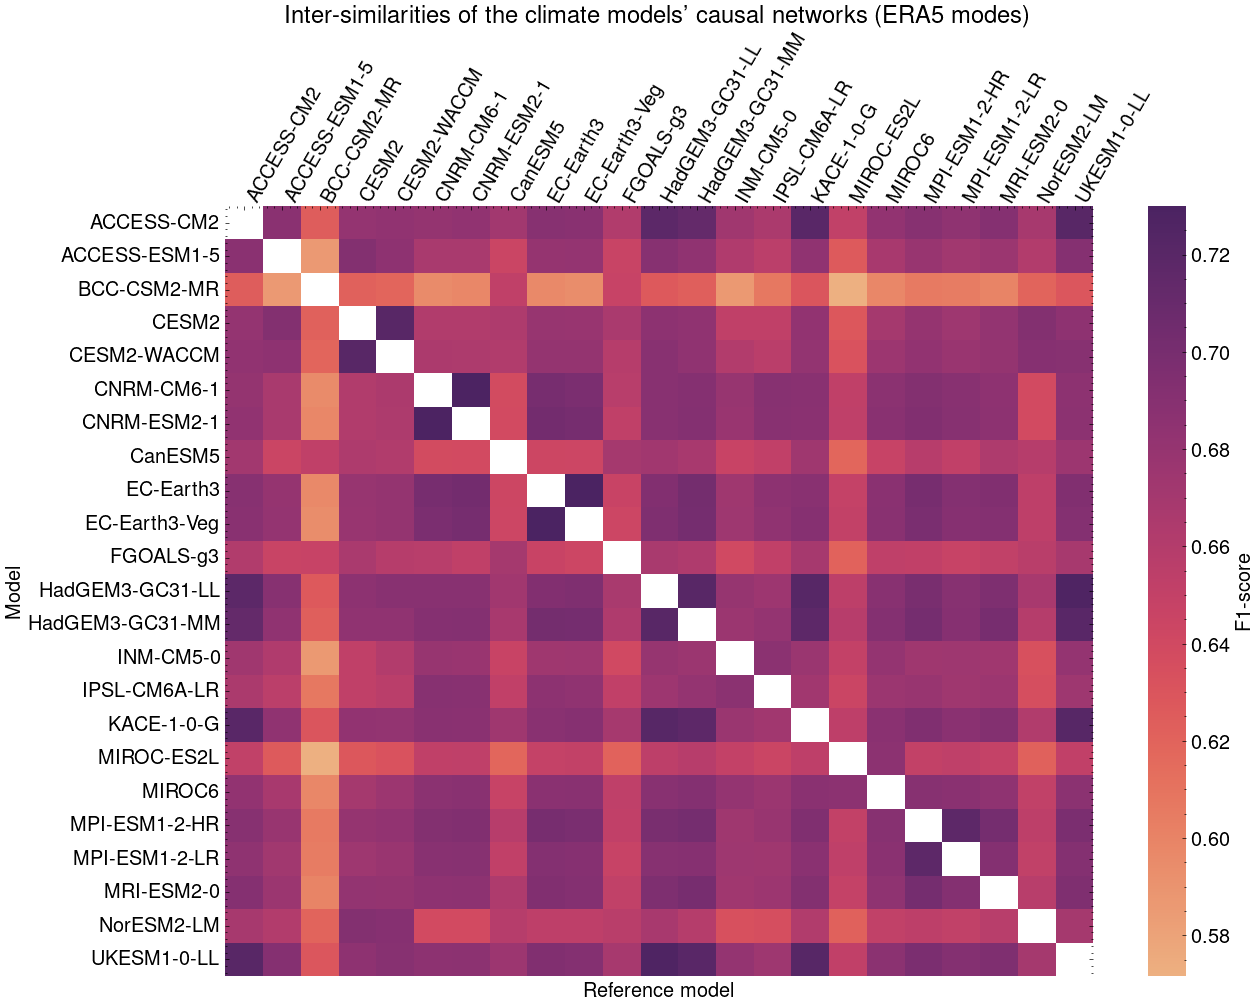

In [21]:
cmap = sn.color_palette("flare", as_cmap=True) #sn.color_palette("magma_r", as_cmap=True)# #sn.color_palette("magma_r", as_cmap=True) # ## # #matplotlib.cm.get_cmap('hot_r')
fig = plt.figure(figsize=(14,10))
params = {'legend.fontsize': 'small',
        #'figure.figsize': (15, 5),
        'axes.labelsize': 'large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)
g = sn.heatmap(df_heatmap_sym, cmap=cmap,annot=False)
g.xaxis.set_ticks_position("top")
g.collections[0].colorbar.set_label("F1-score")
g.set_title('Inter-similarities of the climate models\' causal networks (ERA5 modes)',weight="bold")
g.set_xlabel('Reference model',weight="bold")
g.set_ylabel('Model',weight="bold")
g.set_xticklabels(g.get_xticklabels(), rotation=60,verticalalignment= 'baseline',horizontalalignment= "left")
plt.savefig('interdependence_heatmap_60comps_ERA5.pdf',dpi=300)
plt.show()


In [22]:
import copy
df_f1score_selected_models = df_f1score
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models[["ref_model","ref_ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
#list_discarded = ["CESM2-WACCM-FV2","CESM2-FV2","GFDL-ESM4","GFDL-CM4","ncar"]
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble_reference"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models[df_f1score_selected_models["model_ensemble"].isin(to_keep)]
df_f1score_selected_models = df_f1score_selected_models.drop(columns=["ref_model","ref_ensemble","model","ensemble"])
df_f1score_selected_models= df_f1score_selected_models.groupby(["model_ensemble","model_ensemble_reference"],as_index=False)["F1-score"].mean()
df_ssp370 = copy.copy(df_f1score_selected_models)
df_ssp245 = copy.copy(df_f1score_selected_models)
df_f1score_selected_models["model_ensemble"] = df_f1score_selected_models["model_ensemble"]+"_historical-ssp585"
df_f1score_selected_models["model_ensemble_reference"] = df_f1score_selected_models["model_ensemble_reference"]+"_historical-ssp585"
df_ssp370["model_ensemble"] = df_ssp370["model_ensemble"]+"_historical-ssp370"
df_ssp370["model_ensemble_reference"] = df_ssp370["model_ensemble_reference"]+"_historical-ssp370"
df_ssp245["model_ensemble"] = df_ssp245["model_ensemble"]+"_historical-ssp245"
df_ssp245["model_ensemble_reference"] = df_ssp245["model_ensemble_reference"]+"_historical-ssp245"


In [23]:
import xarray as xr
# old_ind_weights = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_xr_ind_1979-2014_weights_alpha0.0001_timebin1x2_selected_comps.nc")
# old_perf_weights = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/global_xr_perf_era5_1979-2014_weights_alpha0.0001_timebin1x2_selected_comps.nc")

In [24]:
new_xr_ind = df_f1score_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp370 = df_ssp370.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
new_xr_ind_ssp245 = df_ssp245.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
# new_xr_ind_symmetric = df_f1score_selected_models_symmetric.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
# new_xr_ind_ssp370_symmetric = df_ssp370_symmetric.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()
# new_xr_ind_ssp245_symmetric = df_ssp245_symmetric.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble', 'model_ensemble_reference']).to_xarray()

In [25]:
new_xr_ind=new_xr_ind.dcme
new_xr_ind_ssp370=new_xr_ind_ssp370.dcme
new_xr_ind_ssp245=new_xr_ind_ssp245.dcme
# new_xr_ind_symmetric=new_xr_ind_symmetric.dcme
# new_xr_ind_ssp370_symmetric=new_xr_ind_ssp370_symmetric.dcme
# new_xr_ind_ssp245_symmetric=new_xr_ind_ssp245_symmetric.dcme

In [26]:
new_xr_ind= 1 - new_xr_ind.fillna(1.0)
new_xr_ind_ssp370= 1 - new_xr_ind_ssp370.fillna(1.0)
new_xr_ind_ssp245= 1 - new_xr_ind_ssp245.fillna(1.0)
# new_xr_ind_symmetric= 1 - new_xr_ind_symmetric.fillna(1.0)
# new_xr_ind_ssp370_symmetric= 1 - new_xr_ind_ssp370_symmetric.fillna(1.0)
# new_xr_ind_ssp245_symmetric= 1 - new_xr_ind_ssp245_symmetric.fillna(1.0)

In [27]:
new_xr_ind.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp370.attrs={"variable_group":"cme","units":""}
new_xr_ind_ssp245.attrs={"variable_group":"cme","units":""}
# new_xr_ind_symmetric.attrs={"variable_group":"cme","units":""}
# new_xr_ind_ssp370_symmetric.attrs={"variable_group":"cme","units":""}
# new_xr_ind_ssp245_symmetric.attrs={"variable_group":"cme","units":""}

In [9]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import xarray as xr

def barplot(metric: 'xr.DataArray', df_rank: pd.DataFrame, filename: str):
    """Visualize metric as barplot."""
    name = metric.name
    variable_group = metric.variable_group
    units = metric.units

    metric_df = metric.to_dataframe().reset_index()
    metric_df = metric_df.merge(df_rank, on='model', how='left')  # Merge with rank DataFrame
    ylabel = f' {variable_group}'

    figure, axes = plt.subplots(figsize=(10, 7))
    chart = sn.barplot(x='model',
                       y=name,
                       data=metric_df,
                       ax=axes,
                       color="blue")
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
    if variable_group == 'weight':
        chart.set_title('Performance weights')
    else:
        chart.set_title(f'{variable_group} against ERA5 networks')
    chart.set_ylabel(ylabel)
    chart.set_xlabel('')
    chart.grid(True, which='major', color='darkgrey', linestyle='--', linewidth=0.7, axis="y")
    ymin, ymax = chart.get_ylim()
    chart.set_ylim([0.5, 0.72])

    # Add rank annotations on top of each bar
    for index, row in metric_df.iterrows():
        chart.text(index, row[name] + 0.003, f'{int(row["Rank"])}', color='black', ha="center",fontsize=15)

    figure.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(figure)

In [10]:
# Rank the models for the single metric in each dataframe
to_keep_models = set(model.split('_')[0] for model in to_keep)
# Convert to a list for easier use
to_keep_models = list(to_keep_models)
df_plot_perf = df_f1score_global.groupby(["model"],as_index=False)["F1-score"].mean()
df_plot_perf = df_plot_perf[df_plot_perf.isin(to_keep_models).any(axis=1)]

xr_plot_perf = xr.DataArray(data=df_plot_perf["F1-score"].values,dims=["model"],
                            coords=dict(model=("model",df_plot_perf.model.values)),
                            attrs= {"variable_group":"F1-score","units":""},name="F1-score")

df_plot_perf.set_index('model', inplace=True)
ranks_df = df_plot_perf.rank(axis=0, ascending=False, method='min')
ranks_df.rename(columns = {'F1-score':'Rank'}, inplace = True)

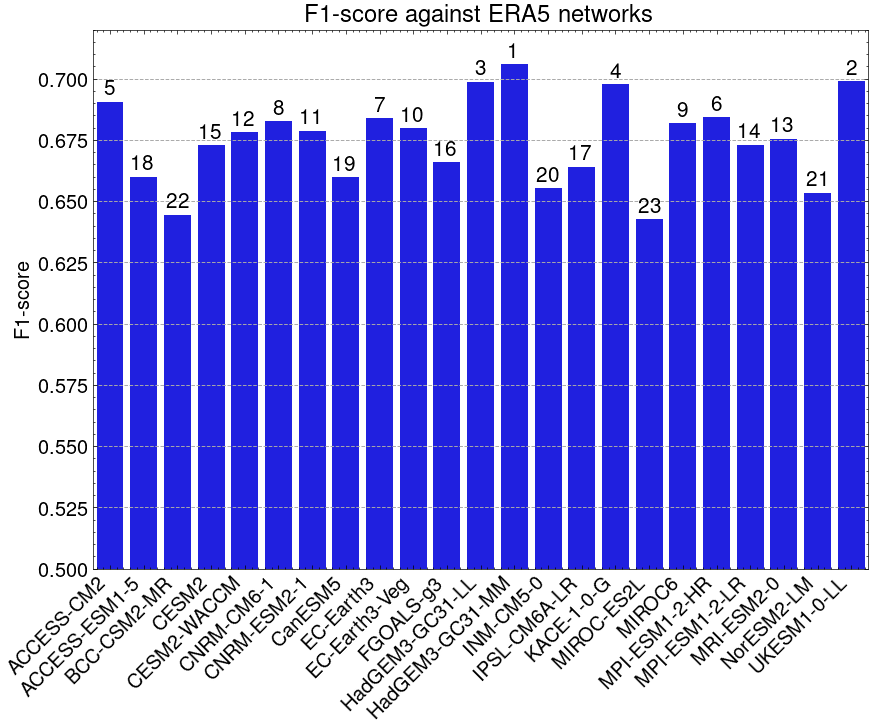

In [30]:
barplot(xr_plot_perf , ranks_df, "performance_60comps_ERA5.pdf")

In [ ]:
df_plot_perf.to_csv("/work/bd1083/b309165/CMIP6_CME/script/jupyter_notebook/CMIP6_CME_2024/performance_60comps_ERA5.csv",index=False)
ranks_df.to_csv("/work/bd1083/b309165/CMIP6_CME/script/jupyter_notebook/CMIP6_CME_2024/performance_60comps_ERA5_ranks.csv",index=False)

In [11]:
# Group the data and calculate the mean F1-score for each model and season
df_grouped = df_f1score_global.groupby(["model", "season"], as_index=False)["F1-score"].mean()
df_grouped = df_grouped[df_grouped.isin(to_keep_models).any(axis=1)] #select models
# Define the season groups as lists
season_groups = ["[12, 1, 2]", "[3, 4, 5]", "[6, 7, 8]", "[9, 10, 11]"]

# Create a dictionary to hold the DataFrames for each season group
df_seasons_grouped = { group: df_grouped[df_grouped["season"] == group]  for group in season_groups
}
xr_seasons_grouped = { group: xr.DataArray(data=df_seasons_grouped[group]["F1-score"].values,dims=["model"],
                            coords=dict(model=("model",df_seasons_grouped[group].model.values)),
                            attrs= {"variable_group":"F1-score","units":""},name="F1-score")  for group in season_groups
}

#Calculate rank of models for each season
df_ranks_grouped = {}
for group in season_groups:
    df_seasons_grouped[group].set_index('model', inplace=True)
    df_ranks_grouped[group] = df_seasons_grouped[group].rank(axis=0, ascending=False, method='min')
    df_ranks_grouped[group].rename(columns = {'F1-score':'Rank'}, inplace = True)

In [12]:
# Save xr_seasons_grouped (xarray DataArrays)
with open('/work/bd1083/b309165/CMIP6_CME/script/jupyter_notebook/CMIP6_CME_2024/xr_seasons_grouped_era5.pkl', 'wb') as f:
    pickle.dump(xr_seasons_grouped, f)

# Save df_ranks_grouped
with open('/work/bd1083/b309165/CMIP6_CME/script/jupyter_notebook/CMIP6_CME_2024/df_ranks_grouped_era5.pkl', 'wb') as f:
    pickle.dump(df_ranks_grouped, f)

In [36]:
#list_discarded = ["FGOALS-f3-L","FGOALS-g3","CESM2-WACCM-FV2","CESM2-FV2","GFDL-ESM4","GFDL-CM4","ncar"]
df_f1score_perf_selected_models = df_f1score_global.groupby(["model","ensemble"],as_index=False)["F1-score"].mean()
df_f1score_perf_selected_models["model_ensemble"] = df_f1score_perf_selected_models[["model","ensemble"]].astype(str).apply('_'.join, axis=1)
df_f1score_perf_selected_models = df_f1score_perf_selected_models[df_f1score_perf_selected_models.isin(to_keep).any(axis=1)]
df_f1score_perf_selected_models = df_f1score_perf_selected_models.drop(columns=["model","ensemble"])
# list_discarded = ['CNRM-CM6-1-HR_r1i1p1f2',
#  'HadGEM3-GC31-LL_r4i1p1f1',
#  'UKESM1-0-LL_r7i1p1f3',
#  'UKESM1-0-LL_r8i1p1f2',
#  'UKESM1-0-LL_r9i1p1f2']
# df_f1score_perf_selected_models = df_f1score_perf_selected_models[~df_f1score_perf_selected_models.isin(list_discarded).any(axis=1)]
# df_f1score_perf_selected_models["model_ensemble"] = df_f1score_perf_selected_models["model_ensemble"]+"_historical-ssp585"
df_f1score_perf_selected_models = df_f1score_perf_selected_models.rename(columns = {'F1-score':'dcme'}, inplace = False).set_index(['model_ensemble'])#.to_xarray()

In [37]:
new_xr_perf =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp370 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp370.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")
new_xr_perf_ssp245 =  xr.DataArray(data=df_f1score_perf_selected_models["dcme"].values,dims=["model_ensemble"],
                            coords=dict(model_ensemble=("model_ensemble",new_xr_ind_ssp245.model_ensemble.data)),
                            attrs= {"variable_group":"cme","units":""},name="dcme")

In [38]:
new_xr_perf = 1.-new_xr_perf
new_xr_perf_ssp370 = 1.-new_xr_perf_ssp370
new_xr_perf_ssp245 = 1.-new_xr_perf_ssp245

In [39]:
new_xr_perf.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp370.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}
new_xr_perf_ssp245.attrs={"variable_group":"cme","units":"","obs_data":"ERA5"}

In [40]:
metric_df = new_xr_perf.to_dataframe().reset_index()
metric_df[['model','ensemble','run']] = metric_df['model_ensemble'].str.split('_',expand=True)
metric_df.groupby(["model"])["dcme"].mean().to_frame()

,dcme
model,
ACCESS-CM2,0.309666
ACCESS-ESM1-5,0.340105
BCC-CSM2-MR,0.354950
CESM2,0.321718
CESM2-WACCM,0.322454
CNRM-CM6-1,0.318751
CNRM-ESM2-1,0.318978
CanESM5,0.340314
EC-Earth3,0.321909


In [41]:
new_xr_perf.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_ind.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")
new_xr_perf_ssp370.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_ind_ssp370.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp370.nc")
new_xr_perf_ssp245.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_perf_era5_60comps_pcmci_parcorr_timebin1_ssp245.nc")
new_xr_ind_ssp245.to_netcdf("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp245.nc")

In [206]:
import xarray as xr
import numpy as np
xr_data = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")

In [238]:
def distance_different_models(data):
    # Extract model names from "model_ensemble" and "model_ensemble_reference"
    model_ensemble_names = data.coords['model_ensemble'].values
    model_ensemble_ref_names = data.coords['model_ensemble_reference'].values

    # Function to extract the model name (ignoring the ensemble member part)
    def extract_model_name(full_name):
        return full_name.split('_')[0]

    # Apply the function to extract model names
    model_names = np.array([extract_model_name(name) for name in model_ensemble_names])
    model_ref_names = np.array([extract_model_name(name) for name in model_ensemble_ref_names])

    # Create a 2D mask to identify where the model names are different
    different_model_mask = np.zeros((len(model_names), len(model_ref_names)), dtype=bool)

    for i, model in enumerate(model_names):
        for j, model_ref in enumerate(model_ref_names):
            if model != model_ref:
                different_model_mask[i, j] = True

    # Create a DataArray from the mask
    different_model_mask = xr.DataArray(
        different_model_mask,
        dims=["model_ensemble", "model_ensemble_reference"],
        coords={"model_ensemble": data.coords['model_ensemble'], "model_ensemble_reference": data.coords['model_ensemble_reference']}
    )

    # Use the mask to calculate the average distance for different models
    different_model_distances = data.where(different_model_mask, drop=True)
    np.fill_diagonal(different_model_distances['dcme'].values, np.nan)
    #print(different_model_distances["dcme"].values)
    average_distance_different_models = different_model_distances.mean()

    print("Average distance between different models:", average_distance_different_models["dcme"].values)

In [239]:
def distance_same_models(data):
    # Extract model names from "model_ensemble" and "model_ensemble_reference"
    model_ensemble_names = data.coords['model_ensemble'].values
    model_ensemble_ref_names = data.coords['model_ensemble_reference'].values

    # Function to extract the model name (ignoring the ensemble member part)
    def extract_model_name(full_name):
        return full_name.split('_')[0]

    # Apply the function to extract model names
    model_names = np.array([extract_model_name(name) for name in model_ensemble_names])
    model_ref_names = np.array([extract_model_name(name) for name in model_ensemble_ref_names])

    # Create a 2D mask to identify where the model names are the same
    same_model_mask = np.zeros((len(model_names), len(model_ref_names)), dtype=bool)

    for i, model in enumerate(model_names):
        for j, model_ref in enumerate(model_ref_names):
            if model == model_ref:
                same_model_mask[i, j] = True

    # Create a DataArray from the mask
    same_model_mask = xr.DataArray(
        same_model_mask,
        dims=["model_ensemble", "model_ensemble_reference"],
        coords={"model_ensemble": data.coords['model_ensemble'], "model_ensemble_reference": data.coords['model_ensemble_reference']}
    )

    # Use the mask to calculate the average distance for the same models
    same_model_distances = data.where(same_model_mask, drop=True)
    np.fill_diagonal(same_model_distances['dcme'].values, np.nan)
    # print(same_model_distances["dcme"].values)
    average_distance = same_model_distances.mean()
    print("Average distance between the same models:", average_distance["dcme"].values)

In [53]:
def min_max_scale(da):
    try:
        mask = da.coords["model_ensemble"] != da.coords["model_ensemble_reference"]
    except Exception as e:
        mask = True
    
    off_diag_vals = da.where(mask)
    
    min_val = off_diag_vals.min()
    max_val = off_diag_vals.max()

    scaled_off_diag = (off_diag_vals - min_val) / (max_val - min_val)
    
    return xr.where(mask, scaled_off_diag, da), min_val, max_val

def median_scale(da):
    try:
        mask = da.coords["model_ensemble"] != da.coords["model_ensemble_reference"]
    except Exception as e:
        mask = True
    
    off_diag_vals = da.where(mask)
    median_val = off_diag_vals.median()

    scaled_off_diag = off_diag_vals/ median_val
    
    return xr.where(mask, scaled_off_diag, da)

# Apply min-max scaling to each DataArray in the Dataset
scaled_data, min_, max_ = min_max_scale(xr_data)

In [244]:
distance_same_models(xr_data)
distance_different_models(xr_data)

Average distance between the same models: 0.27501821848703933
Average distance between different models: 0.3296468857706934


In [240]:
distance_same_models(xr_data / xr_data.median())
distance_different_models(xr_data / xr_data.median())

Average distance between the same models: 0.8514899002408298
Average distance between different models: 1.0206269076418149


In [245]:
distance_same_models(scaled_data)
distance_different_models(scaled_data)

Average distance between the same models: 0.0808242628309452
Average distance between different models: 0.34705460878272576


In [261]:
b=0.9
def f(x, b):
    output = 1 / (1 + np.exp(-(x / b)**2))
    return output
print(f(1.02,b)/f(0.85,b))
print(f(1.02,b))
print(f(0.85,b))

1.104198472878647
0.7832053694314374
0.7092976386660089


In [259]:
import numpy as np
from scipy.optimize import minimize

# Define the function f(x)
def f(x, b):
    return 1 / (1 + np.exp(-(x / b)**2))

# Define the difference function D(b)
def D(b):
    return (1 + f(1.02062, b)) / (1 + f(0.8514899, b))

# Define the objective function (negative of D(b) to use minimize)
def objective(b):
    return -D(b)

# Initial guess for b
initial_guess = 1.0

# Use scipy.optimize.minimize to find the b that maximizes the difference
result = minimize(objective, initial_guess, bounds=[(0.01, 2.)])

# Extract the optimal value of b
optimal_b = result.x[0]
print("Optimal b:", optimal_b)

# Calculate the maximum difference
max_difference = D(optimal_b)
print("Maximum difference:", max_difference)


Optimal b: 0.7827185116810215
Maximum difference: 1.0453129288205516


In [219]:
print((xr_data / xr_data.median()).min())
print((xr_data / xr_data.median()).max())
print((xr_data / xr_data.median()).mean())

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 0.0
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 1.435
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 1.001


In [49]:
import xarray as xr
import numpy as np

# Function to symmetrize a DataArray
def symmetrize_dataarray(data_array):
    # Get the shape of the array
    shape = data_array.shape
    
    # Initialize an array to store the symmetrized values
    sym_data = np.zeros(shape)
    
    # Loop through each element and average the symmetric elements
    for i in range(shape[0]):
        for j in range(shape[1]):
            sym_data[i, j] = (data_array[i, j] + data_array[j, i]) / 2
    
    # Create a new DataArray with the symmetrized data
    sym_data_array = xr.DataArray(sym_data, dims=data_array.dims, coords=data_array.coords)
    return sym_data_array

# Function to symmetrize an entire Dataset
def symmetrize_dataset(dataset):
    symmetrized_vars = {}
    for var_name in dataset.data_vars:
        symmetrized_vars[var_name] = symmetrize_dataarray(dataset[var_name])
    
    # Create a new dataset with the symmetrized variables
    symmetrized_dataset = xr.Dataset(symmetrized_vars, coords=dataset.coords)
    return symmetrized_dataset

# Create a sample xarray Dataset with two variables and required dimensions
data1 = np.random.rand(4, 4)  # Replace with your actual data
data2 = np.random.rand(4, 4)  # Replace with your actual data
model_ensemble = ['model1', 'model2', 'model3', 'model4']
model_ensemble_reference = ['model1', 'model2', 'model3', 'model4']

dataset = xr.Dataset(
    {
        "variable1": (["model_ensemble", "model_ensemble_reference"], data1)
    },
    coords={"model_ensemble": model_ensemble, "model_ensemble_reference": model_ensemble_reference}
)

# Symmetrize the dataset
symmetrized_dataset = symmetrize_dataset(dataset)

# Print the original and symmetrized Datasets for comparison
print("Original Dataset:\n", dataset["variable1"])
print("Symmetrized Dataset:\n", symmetrized_dataset["variable1"])

Original Dataset:
 <xarray.DataArray 'variable1' (model_ensemble: 4, model_ensemble_reference: 4)> Size: 128B
array([[0.42864916, 0.99541257, 0.82777852, 0.71286406],
       [0.6169399 , 0.34354867, 0.18142708, 0.76937107],
       [0.2709323 , 0.3220637 , 0.80981925, 0.3859888 ],
       [0.64509969, 0.13429436, 0.98935621, 0.26402472]])
Coordinates:
  * model_ensemble            (model_ensemble) <U6 96B 'model1' ... 'model4'
  * model_ensemble_reference  (model_ensemble_reference) <U6 96B 'model1' ......
Symmetrized Dataset:
 <xarray.DataArray 'variable1' (model_ensemble: 4, model_ensemble_reference: 4)> Size: 128B
array([[0.42864916, 0.80617623, 0.54935541, 0.67898187],
       [0.80617623, 0.34354867, 0.25174539, 0.45183271],
       [0.54935541, 0.25174539, 0.80981925, 0.68767251],
       [0.67898187, 0.45183271, 0.68767251, 0.26402472]])
Coordinates:
  * model_ensemble            (model_ensemble) <U6 96B 'model1' ... 'model4'
  * model_ensemble_reference  (model_ensemble_reference) <

In [2]:
import xarray as xr
import numpy as np
xr_data = xr.open_dataset("/work/bd1083/b309165/CMIP6_CME/results/results_CMIP6/xr_ind_era5_60comps_pcmci_parcorr_timebin1_ssp585.nc")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_model_name(full_name):
    """
    Extract model name from model_ensemble.

    Parameters:
    - full_name (str): Full model name including ensemble information.

    Returns:
    - str: Model name extracted from the full name.
    """
    return full_name.split('_')[0]

def calculate_cross_model_distances(distance_df):
    """
    Calculate cross-model distances for all unique models in the DataFrame.

    Parameters:
    - distance_df (pd.DataFrame): DataFrame containing distances between model members.

    Returns:
    - list: List of arrays containing cross-model distances for each unique model.
    - list: List of unique model names.
    """
    unique_models = distance_df['model_ensemble'].apply(extract_model_name).unique()
    cross_model_distances = []
    
    for model in unique_models:
        # Calculate distances between current model and all other models
        for ref_model in unique_models:
            if ref_model != model:
                # Calculate distances between model and reference model
                distances = distance_df.loc[(distance_df['model_ensemble'].apply(extract_model_name) == model) & 
                                            (distance_df['model_ensemble_reference'].apply(extract_model_name) == ref_model), 'dcme'].values

                distances = distances[(distances != 0)]
                cross_model_distances.extend(distances)
    
    return cross_model_distances, unique_models

def calculate_inter_model_distances(distance_df):
    """
    Calculate inter-model distances for all unique models in the DataFrame.

    Parameters:
    - distance_df (pd.DataFrame): DataFrame containing distances between model members.

    Returns:
    - list: List of arrays containing inter-model distances for each unique model.
    - list: List of unique model names.
    """
    unique_models = distance_df['model_ensemble'].apply(extract_model_name).unique()
    inter_model_distances = []
    
    for model in unique_models:
        # Calculate distances between current model and all other models
        model_distances = []
        for ref_model in unique_models:
            if ref_model == model:
                # Calculate distances between model and reference model
                distances = distance_df.loc[(distance_df['model_ensemble'].apply(extract_model_name) == model) & 
                                            (distance_df['model_ensemble_reference'].apply(extract_model_name) == ref_model), 'dcme'].values

                distances = distances[(distances != 0)]
                model_distances.extend(distances)
        
        inter_model_distances.append(model_distances)
    
    return inter_model_distances, unique_models


In [4]:
print((xr_data/ xr_data.median()).min())
print((xr_data/ xr_data.median()).max())
print((xr_data/ xr_data.median()).mean())

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 0.0
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 1.435
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    dcme     float64 8B 1.001


In [5]:
# Calculate inter-model distances
df = (xr_data/ xr_data.median()).dcme.to_dataframe()
df = df.reset_index()
inter_model_distances, model_names = calculate_inter_model_distances(df)
cross_distances, _ = calculate_cross_model_distances(df)
inter_model_distances.append(cross_distances)
model_names = list(model_names)
model_names.append("Intermodel only")

print(cross_distances)
# Plotting boxplot
import pylab
params = {'legend.fontsize': 'medium',
        #'figure.figsize': (15, 5),
        'axes.labelsize': 'x-large',
        'axes.titlesize':'xx-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(10, 7))

plt.boxplot(inter_model_distances, labels=model_names, vert=False)
plt.xlabel(r'Distance ($1-F_1$ score)')
plt.title('Distances between ensembles of the same model and intermodel distances (ERA5 reference)')
plt.grid(True, which='major', color='darkgrey', linestyle='--', linewidth=0.7, axis="x")
plt.axvline(x=0.9, color='orange', linestyle='--')
plt.tight_layout()
plt.savefig("calibration_sigma_s_ERA5.pdf",dpi=300)
plt.show()
plt.close()

[0.9374184072382058, 0.9198471898455505, 0.9341066460202481, 0.9503491056936145, 0.9453137172622167, 0.9545366457603012, 0.9141636301299054, 0.9216315458544314, 0.9141008322616326, 1.2289342573766, 1.2698565753050608, 1.2579215394368917, 0.9523459574310534, 0.9582578978865057, 0.9587022371127422, 0.9812842136981036, 1.0009278197001703, 0.9701577598300393, 0.9410183772449635, 0.9605021642965594, 0.9444536032784228, 0.9766018683927978, 0.9808256644944682, 0.9667253454447103, 0.9731709131310744, 0.9653503850661879, 0.9908086323630666, 0.939195883110255, 0.9733761931280884, 0.9647095042836655, 0.9810823628267246, 0.9651974289732385, 0.9891848756946888, 0.9582836587679376, 0.9778906716432512, 0.9926675317874593, 0.9599751309318505, 0.9568872503081256, 0.9747971119940441, 0.9461515532088559, 0.9416049539230116, 0.9577071072892559, 0.9640435241043085, 0.9518945926932744, 0.9465574194204301, 0.9597522111554279, 0.9418705504676889, 0.9708952221194975, 0.9523961612668089, 0.9638971181037409, 1.0

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7ffb8667f430> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>